<a href="https://colab.research.google.com/github/jjrodcast/Trabajo-Machine-Learning/blob/master/Course_Food_Demand_Forecasting_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Food Demand Forecasting**

Página de concurso: Analytics Vidhya [Food Demand Forecasting](https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/)

## 1. Entendimiento del Problema

### 1.1 Panorama General
El pronóstico de demanda es muy importante para el crecimiento de los negocios en línea. Sin los procesos de previsión de demanda correctos, puede ser casi imposible tener la cantidad adecuada de insumos en un momento dado.

Entrando en detalle, un servicio de entrega de alimentos tiene que lidiar con muchas cantidades de materias primas, lo cuál es un indicador muy importante para que las empresas tengan con la mayor precisión posible la demanda diaria y mensual. El hecho de tener demasiado inventario en el almacén significa un mayor riesgo de desperdicio de materia prima, por otro lado el poco inventario podría llevar a la falta de abastecimiento lo que podría resultar en un mayor problema el cual es hacer que los clientes busquen soluciones en nuestros competidores.

### 1.2. Planteamiento del Problema
El cliente que se tiene es una ***empresa de entrega de comida*** que opera en distintas ciudades. Dicha empresa tiene varios centros de cumplimiento en dichas ciudades para enviar comida a sus clientes. Se quiere tener un ***pronóstico de la demanda de dichos centros*** para las próximas semanas, de tal manera que puedan ***planificar el stock de materias primas***.

Tener en cuenta que, la reposición de las materias primas se realiza semanalmente y, debido a que la materia prima es perecedera, la planificación de las adquisiciones es de suma importancia. También, la asignación de personal de cada centro es un importante para que el pronóstico sea realmente útil.

**Objetivo:** Predecir la demanda para las próximas 10 semanas para la combinación de los alimentos de los centros en el conjunto de entrenamiento.

##2. Análisis y Visualización de datos

### 2.1 Importamos Librerías

In [7]:
# Importamos las librerias 
%matplotlib inline
!pip install catboost
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xg
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

sns.set(style="white")

In [8]:
!mkdir data
!wget "https://drive.google.com/uc?export=download&id=1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP" -O data/fulfilment_center_info.csv
!wget "https://drive.google.com/uc?export=download&id=19v-eC9LKjbAH0DMqQpi8Sb0XVxnNm9uq" -O data/meal_info.csv
!wget "https://drive.google.com/uc?export=download&id=1-zCbExblslglkus85ZCTNWwDh3TiEgkl" -O data/test.csv
!wget "https://drive.google.com/uc?export=download&id=1DZj2egxfzXYltmL_1M_atDHXMwz6IsR_" -O data/train.csv

mkdir: cannot create directory ‘data’: File exists
--2020-04-29 22:40:15--  https://drive.google.com/uc?export=download&id=1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP
Resolving drive.google.com (drive.google.com)... 74.125.203.102, 74.125.203.100, 74.125.203.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.203.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ql4el9bthl7qjojq9n0dvcokb1auca49/1588200000000/01100318546325464434/*/1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP?e=download [following]
--2020-04-29 22:40:16--  https://doc-0c-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ql4el9bthl7qjojq9n0dvcokb1auca49/1588200000000/01100318546325464434/*/1EG9_l6a5rRlTSzEwlNijqLuY7bxW_iuP?e=download
Resolving doc-0c-00-docs.googleusercontent.com (doc-0c-00-docs.googleusercontent.com)... 64.233.187.132, 2404:6800:4008:c05::84
Connect

### 2.2. Información del Cojunto de Entrenamiento

In [0]:
# Cargamos los datos 
fulfilment_center_info = pd.read_csv('data/fulfilment_center_info.csv')
meal_info = pd.read_csv('data/meal_info.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [10]:
# Mostramos los primeros datos de entrenamiento
print("Total de registros Train set: ", train.shape)
train.head()

Total de registros Train set:  (456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


Información estadística del Conjunto de Entrenamiento

In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,456548.0,1.250096e+06,144354.822378,1000000.00,1124998.75,1250183.50,1375140.25,1499999.00
week,456548.0,7.476877e+01,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,8.210580e+01,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2.024337e+03,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,3.322389e+02,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,3.541566e+02,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,8.115247e-02,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,1.091999e-01,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,2.618728e+02,395.922798,13.00,54.00,136.00,324.00,24299.00


### 2.3. Información del Conjunto de Pruebas

In [12]:
# Mostramos los primeros datos de pruebas
print("Total de registros Test set: ", test.shape)
test.head()

Total de registros Test set:  (32573, 8)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


Información estadística de Conjunto de Pruebas

In [13]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,32573.0,1.248476e+06,144158.048324,1000085.00,1123969.00,1247296.00,1372971.00,1499996.00
week,32573.0,1.504778e+02,2.864072,146.00,148.00,150.00,153.00,155.00
center_id,32573.0,8.190173e+01,45.950455,10.00,43.00,76.00,110.00,186.00
meal_id,32573.0,2.032068e+03,547.199004,1062.00,1558.00,1993.00,2569.00,2956.00
checkout_price,32573.0,3.418544e+02,153.893886,67.90,214.43,320.13,446.23,1113.62
base_price,32573.0,3.564936e+02,155.150101,89.24,243.50,321.13,455.93,1112.62
emailer_for_promotion,32573.0,6.643539e-02,0.249045,0.00,0.00,0.00,0.00,1.00
homepage_featured,32573.0,8.135572e-02,0.273385,0.00,0.00,0.00,0.00,1.00


### 2.4. Información de los Centros y Comidas

In [14]:
# Mostramos primeros datos de los centros
print("Total de registros de centros:", fulfilment_center_info.shape)
fulfilment_center_info.head()

Total de registros de centros: (77, 5)


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [15]:
# Valores únicos de centros
center_types = pd.DataFrame({'center_type': fulfilment_center_info['center_type'].unique() }).reset_index()
center_types

,index,center_type
0,0,TYPE_A
1,1,TYPE_B
2,2,TYPE_C


In [16]:
# Mostramos primeros datos de las comidas
print("Total de registros de comidas:", meal_info.shape)
meal_info.head()

Total de registros de comidas: (51, 3)


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [17]:
cuisine_category = meal_info.groupby(['cuisine', 'category']).count()
cuisine_category.rename(columns={'meal_id': 'total'})

total
cuisine     category           
Continental Beverages         3
            Fish              3
            Pizza             3
            Seafood           3
Indian      Beverages         3
            Biryani           3
            Desert            3
            Rice Bowl         3
Italian     Beverages         3
            Pasta             3
            Salad             3
            Sandwich          3
Thai        Beverages         3
            Extras            3
            Other Snacks      3
            Soup              3
            Starters          3

### 2.5. Verificación de datos faltantes

In [18]:
# Verificamos si hay valores nulos en el conjunto de entrenamiento
train.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [19]:
# Verificamos si hay valores nulos en centros
fulfilment_center_info.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [20]:
# Verificamos si hay valores nulos en comidas
meal_info.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

### 2.6. Combinamos la data de entrenamiento, centros y comidas

In [0]:
# Juntamos los datos de train y test
train = pd.merge(train, fulfilment_center_info, how='left', left_on='center_id', right_on='center_id')
train = pd.merge(train, meal_info, how='left', left_on='meal_id', right_on='meal_id')

test = pd.merge(test, fulfilment_center_info, how='left', left_on='center_id', right_on='center_id')
test = pd.merge(test, meal_info, how='left', left_on='meal_id', right_on='meal_id')

###2.7. Análisis de variables y Visualizaciones

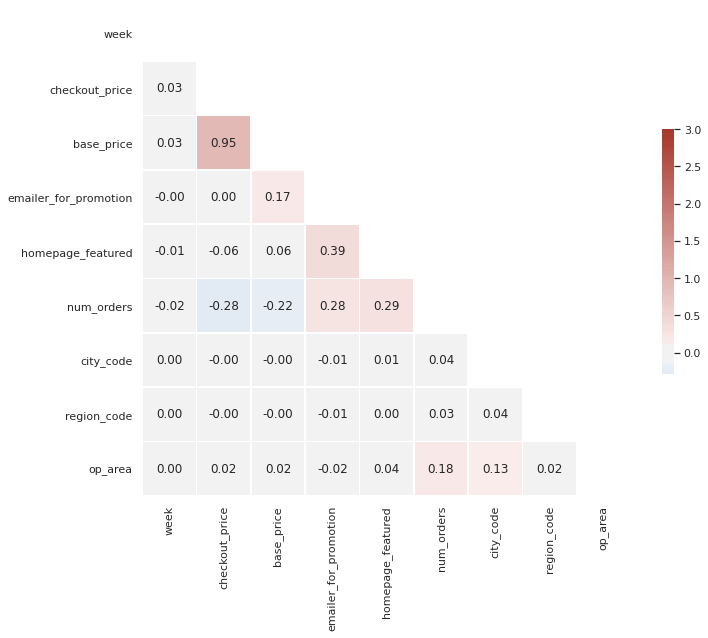

In [22]:
correlation = train.drop(['id', 'center_id', 'meal_id'], axis=1).corr(method='pearson')
mask = np.ones_like(correlation, dtype=np.bool)
mask = np.triu(mask)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=3., annot=True, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Text(0, 0.5, 'Cantidad de pedidos')

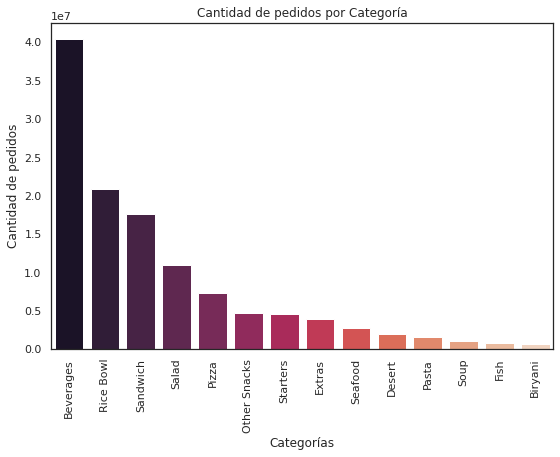

In [23]:
# Visualización de Categorías vs Cantidad de Pedidos
plt.figure(figsize=(9, 6))
group_categories=train.groupby('category')['num_orders'].sum().sort_values(ascending=False).reset_index()
sns.barplot(x='category', y='num_orders', data=group_categories, palette='rocket')
plt.xticks(rotation = 90)
plt.title("Cantidad de pedidos por Categoría")
plt.xlabel("Categorías")
plt.ylabel("Cantidad de pedidos")

Podemos visualizar que las tres categorías más solicitadas son ***Beverages*** , ***Rice Bowl*** y ***Sandwich***

Text(0, 0.5, 'Cantidad de pedidos')

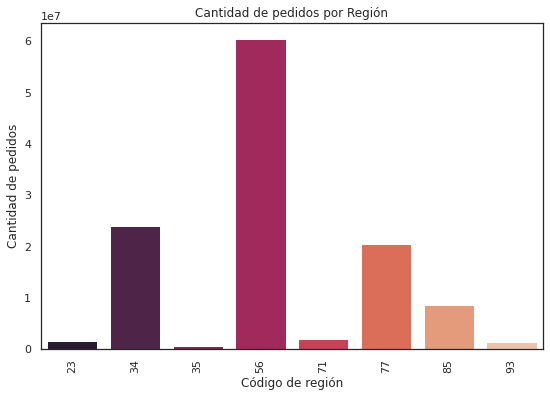

In [24]:
# Visualización de Región vs Cantidad de Pedidos
plt.figure(figsize=(9, 6))
group_categories=train.groupby('region_code')['num_orders'].sum().sort_values(ascending=False).reset_index()
sns.barplot(x='region_code', y='num_orders', data=group_categories, palette='rocket')
plt.xticks(rotation = 90)
plt.title("Cantidad de pedidos por Región")
plt.xlabel("Código de región")
plt.ylabel("Cantidad de pedidos")

La región que **56** es la que tiene mayor pedidos

Text(0, 0.5, 'Cantidad de pedidos')

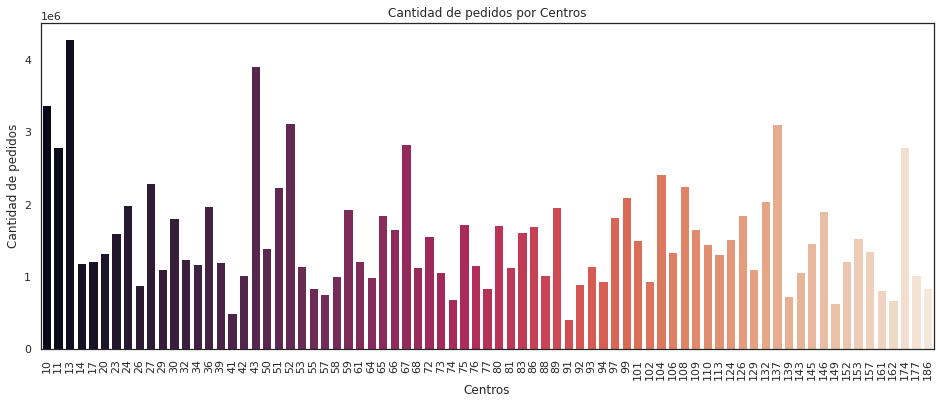

In [25]:
# Visualización de Categorías vs Cantidad de Pedidos
plt.figure(figsize=(16, 6))
group_categories=train.groupby('center_id')['num_orders'].sum().sort_values(ascending=False).reset_index()
sns.barplot(x='center_id', y='num_orders', data=group_categories, palette='rocket')
plt.xticks(rotation = 90)
plt.title("Cantidad de pedidos por Centros")
plt.xlabel("Centros")
plt.ylabel("Cantidad de pedidos")

La distribución de pedidos en los centros no tiene un patrón que se pueda identificar claramente.

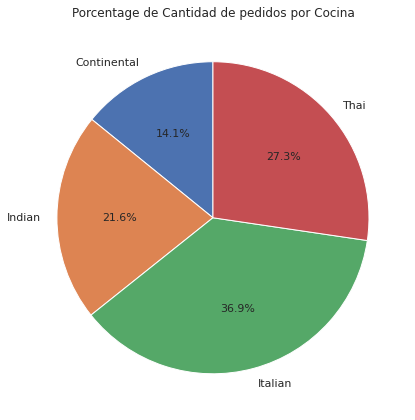

In [26]:
# Visualización de Cocinas vs Cantidad de Pedidos
plt.figure(figsize=(6, 6))
cuisine_group = train.groupby(['cuisine'])
plt.title("Porcentage de Cantidad de pedidos por Cocina")
plt.pie(cuisine_group['num_orders'].sum(),
        labels=cuisine_group['num_orders'].sum().index,
        shadow=False,
        autopct='%1.1f%%',
        pctdistance=0.6,
        startangle=90,
        textprops={'fontsize': 11})
plt.tight_layout()

Podemos visualizar el tipo de comida que prefieren los consumidores es la ***Italiana*** y la menos preferida es ***Continental***

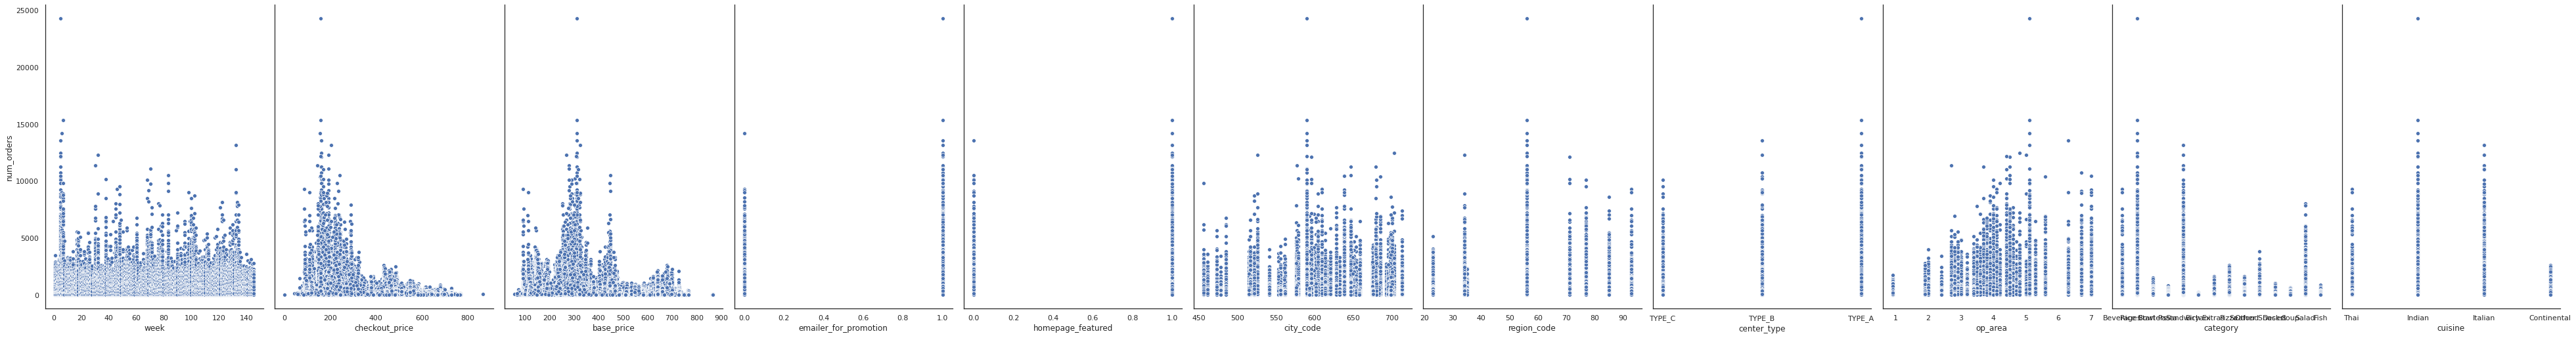

In [27]:
# Visualizamos las variables vs target
p = sns.pairplot(train, x_vars=['week','checkout_price','base_price','emailer_for_promotion','homepage_featured','city_code','region_code','center_type','op_area','category','cuisine'], y_vars='num_orders', height=7, aspect=0.7)

Aunque no es tan notorio, se puede visualizar **outliers** en los gráficos, más adelante veremos uno de los gráficos a detalle

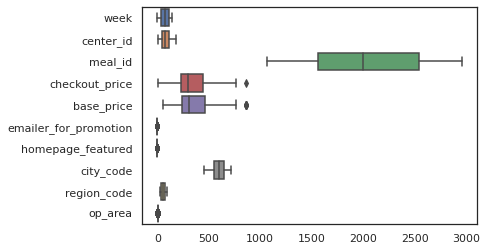

In [28]:
# Visualizamos el boxplot de las variables.
sns.boxplot(data=train.drop(columns=["id","num_orders"]), orient="h")

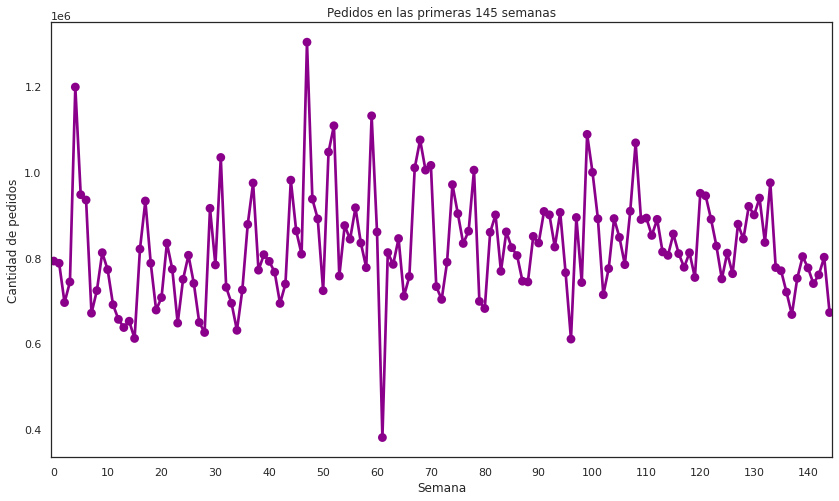

In [29]:
# Visualizamos el patrónpatrón de Cantidad de Pedidos durante las primeras 145 semanas
plt.figure(figsize=(14, 8))
group_week = train.groupby('week').sum().reset_index()
sns.pointplot(x=group_week['week'], y=group_week['num_orders'], color='darkmagenta')
plt.title("Pedidos en las primeras 145 semanas")
plt.xticks(range(0, 150, 10), range(0, 160, 10))
plt.xlabel("Semana")
plt.ylabel("Cantidad de pedidos")
plt.show()

Se puede visualizar que la menor cantidad de pedidos se hizo en la ***semana 60*** y la mayor cantidad de pedidos entre la ***semana 40 y 50***

###2.8. Eliminación de outliers

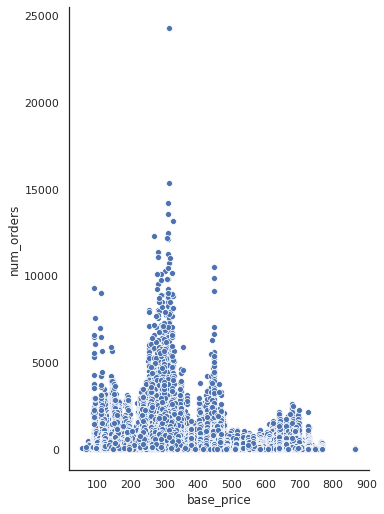

In [30]:
# Visualizamos las la cantidad de pedidos por semana
sns.pairplot(train, x_vars=['base_price'], y_vars='num_orders', height=7, aspect=0.7)
plt.show()

Como se puede visualizar en el gráfico, hay un valor que puede considerarse outlier, por lo cual tomaremos todos los valores menores a **1500** para eliminar dichos outliers

In [0]:
# Eliminamos dicho outlier
train = train[(train['num_orders'] < 15000)]

##3. Realizamos Feature Enginnering
Para esto nos hemos basamos del siguiente notebook: [Food Demand Forecasting](https://github.com/yashkim77/AV_Food_Demand_Challenge) , hicimos algunas modificaciones en la generación de columnas

###3.1. Escalamiento de datos y generación de nuevos features

In [32]:
# Aplicando escalamiento logarítmico a variables de precios y target
train['checkout_price'] = np.log1p(train['checkout_price'])
train['base_price'] = np.log1p(train['base_price'])
train['num_orders'] = np.log1p(train['num_orders'])

test['checkout_price'] = np.log1p(test['checkout_price'])
test['base_price'] = np.log1p(test['base_price'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [33]:
# Generamos la columna descuento en base al precio base y el precio de venta
train['discount'] = (train['base_price'] - train['checkout_price']) / train['base_price']
test['discount'] = (test['base_price'] - test['checkout_price']) / test['base_price']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# Ordenamos los datos por centro, comida y semana
train = train.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)
test = test.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [0]:
# Generamos la columna de diferencia de precios
train['diff_price_week'] = train['checkout_price'] - train['checkout_price'].shift(1)
test['diff_price_week'] = test['checkout_price'] - test['checkout_price'].shift(1)
train['diff_price_week'] = train['diff_price_week'].fillna(0)
test['diff_price_week'] = test['diff_price_week'].fillna(0)

In [0]:
# Generamos la columna de promedio de número de ordenes por centro y comida
train_center_meal_orders_group = train.groupby(['center_id', 'meal_id'])['num_orders'].mean().reset_index()
train_center_meal_orders_group = train_center_meal_orders_group.rename(columns={'num_orders': 'mean_orders'})
train = pd.merge(train, train_center_meal_orders_group, how='left', left_on=['center_id', 'meal_id'], right_on=['center_id', 'meal_id'])
test = pd.merge(test, train_center_meal_orders_group, how='left', left_on=['center_id', 'meal_id'], right_on=['center_id', 'meal_id'])
test['mean_orders'] = test['mean_orders'].fillna(0)

In [0]:
# Creamos data con variables categoricas para CatBoostRegression
train_categorical = train.copy()
test_categorical = test.copy()
train_categorical['center_id'] = train_categorical['center_id'].astype(np.object)
test_categorical['center_id'] = test_categorical['center_id'].astype(np.object)
train_categorical['meal_id'] = train_categorical['meal_id'].astype(np.object)
test_categorical['meal_id'] = test_categorical['meal_id'].astype(np.object)
train_categorical['city_code'] = train_categorical['city_code'].astype(np.object)
test_categorical['city_code'] = test_categorical['city_code'].astype(np.object)
train_categorical['region_code'] = train_categorical['region_code'].astype(np.object)
test_categorical['region_code'] = test_categorical['region_code'].astype(np.object)

X_train_categorical = train_categorical.drop(['id', 'num_orders'], axis = 1)
X_test_categorical = test_categorical.drop(['id'], axis = 1)

In [0]:
# Creamos dummies
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test)

In [0]:
X_train = train.drop(['id', 'center_id', 'meal_id', 'num_orders'], axis=1)
X_train_dummies = train_dummies.drop(['id', 'center_id', 'meal_id', 'num_orders'], axis=1)
Y_train = train['num_orders']

# Predicción
ids = test['id']
X_test = test.drop(['id','center_id', 'meal_id'], axis=1)
X_test_dummies = test_dummies.drop(['id','center_id', 'meal_id'], axis=1)

### 3.2. Visualización de correlación con nuevos datos

[]

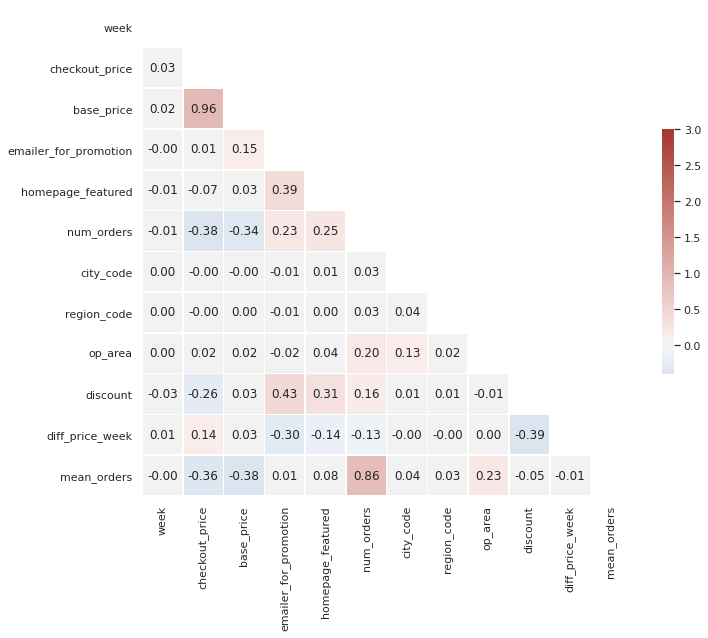

In [40]:
correlation = train.drop(['id', 'center_id', 'meal_id'], axis=1).corr()
mask = np.ones_like(correlation, dtype=np.bool)
mask = np.triu(mask)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=3., annot=True, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.plot()

In [0]:
#Fuente: https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
def plot_learning_curve(model, X, Y, cv=5):
  # Create CV training and test scores for various training set sizes
  train_sizes, train_scores, test_scores = learning_curve(model,X, Y,cv=cv)

  # Create means and standard deviations of training set scores
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)

  # Create means and standard deviations of test set scores
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # Draw lines
  plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
  plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

  # Draw bands
  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  # Create plot
  plt.title("Learning Curve")
  plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

## 4. Modelos y Métricas

Aplicamos algunos modelos y la métrica que se usa para evaluar los modelos son **Mean Square Error** y **Mean Square Logarithmic Error**

### 4.1 Árbol de Decisiones

#### Prueba 1: Aplicamos árbol de decisión con KFolds

Score Promedio
Train      = 0.8366
Validation = 0.8212
RMSLE Promedio
Train      = 9.427
Validation = 9.815
Base Line Compare = 19.02


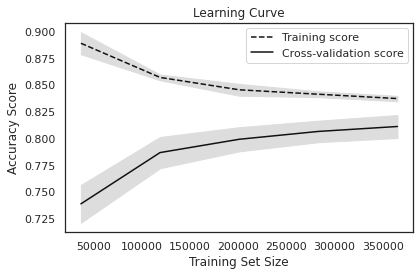

In [42]:
kfolds = KFold(n_splits=5, shuffle=True)

y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], [], []

model = DecisionTreeRegressor(max_depth = 12)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_train,model.predict(x_train))))
    val_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))
    y_val[:]=y.mean()
    base_score.append(100 * np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

plot_learning_curve(model, x, y)

#### Prueba 2: Aplicamos árbol de decisión con train/test split

Score Promedio
Train      = 0.837
Validation = 0.82
RMSLE Promedio
Train      = 9.403
Validation = 9.879


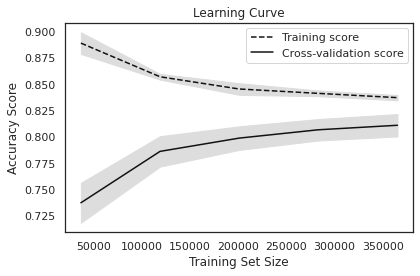

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X_train_dummies, Y_train, test_size=0.30)

model = DecisionTreeRegressor(max_depth = 12)
model.fit(x_train, y_train)

print(f'Score Promedio')
print(f'Train      = {model.score(x_train, y_train):.4}')
print(f'Validation = {model.score(x_test, y_test):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {(100*np.sqrt(mean_squared_log_error(y_train, model.predict(x_train)))):.4}')
print(f'Validation = {(100*np.sqrt(mean_squared_log_error(y_test, model.predict(x_test)))):.4}')

plot_learning_curve(model, X_train_dummies, Y_train)

#### Prueba 3: Aplicamos árbol de decisión con profundidad 14

Score Promedio
Train      = 0.8514
Validation = 0.8225
RMSE Promedio
Train      = 9.033
Validation = 9.793


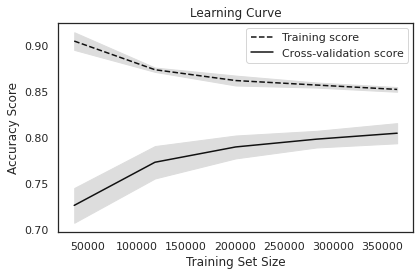

In [44]:
kfolds = KFold(n_splits=5, shuffle=True)

y = Y_train
x = X_train_dummies

train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []
model = DecisionTreeRegressor(max_depth = 14, min_samples_leaf=3)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmsle.append(100*np.sqrt(mean_squared_log_error(y_train,model.predict(x_train))))
    val_rmsle.append(100*np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))
    
print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

plot_learning_curve(model, X_train_dummies, Y_train)

### 4.2 Random Forest - Regresión

#### Prueba 1: Aplicamos RandomForest con KFolds

In [45]:
# Información revisada https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
kfolds = KFold(n_splits=5, shuffle=True)

y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmse, val_rmse = [], [], [], [], []

model = RandomForestRegressor(n_estimators = 160, max_depth=12,min_samples_leaf=3)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmse.append(100*np.sqrt(mean_squared_log_error(y_train,model.predict(x_train))))
    val_rmse.append(100*np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))
    y_val[:]=y.mean()
    base_score.append(100*np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))


print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmse):.4}')
print(f'Validation = {np.mean(val_rmse):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

Score Promedio
Train      = 0.8444
Validation = 0.833
RMSE Promedio
Train      = 9.232
Validation = 9.529
Base Line Compare = 18.85


#### Prueba 2. Aplicamos RandomForest con train/test split

In [46]:
y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmse, val_rmse = [], [], [], [], []
model = RandomForestRegressor(n_estimators = 200, max_depth=12, min_samples_leaf=3)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmse.append(100*np.sqrt(mean_squared_log_error(y_train,model.predict(x_train))))
    val_rmse.append(100*np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))
    y_val[:]=y.mean()
    base_score.append(100*np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))


print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmse):.4}')
print(f'Validation = {np.mean(val_rmse):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

Score Promedio
Train      = 0.8444
Validation = 0.833
RMSE Promedio
Train      = 9.232
Validation = 9.529
Base Line Compare = 18.85


### 4.3 Gradient Boosting Regression

#### Prueba 1: GradientBoosting cambio de hiperparámetros

In [47]:
kfolds = KFold(n_splits=4, shuffle=True)

y = Y_train
x = X_train_dummies

base_score, train_scores, val_scores, train_rmse, val_rmse = [], [], [], [], []

model = GradientBoostingRegressor(loss='ls',
                                n_estimators=180, max_depth=12,
                                learning_rate=0.1, min_samples_leaf=5,
                                min_samples_split=8)

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    model.fit(x_train, y_train)
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    train_rmse.append(100*np.sqrt(mean_squared_log_error(y_train,model.predict(x_train))))
    val_rmse.append(100*np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))
    y_val[:]=y.mean()
    base_score.append(100*np.sqrt(mean_squared_log_error(y_val,model.predict(x_val))))
    
print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSE Promedio')
print(f'Train      = {np.mean(train_rmse):.4}')
print(f'Validation = {np.mean(val_rmse):.4}')
print(f'Base Line Compare = {np.mean(base_score):.4}')

Score Promedio
Train      = 0.9132
Validation = 0.8636
RMSE Promedio
Train      = 7.081
Validation = 8.766
Base Line Compare = 19.33


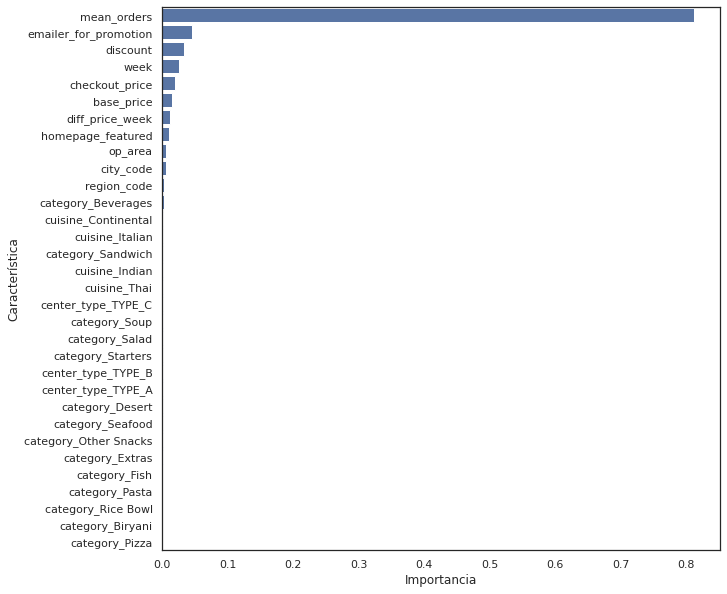

In [48]:
importances = pd.DataFrame({ 'importance': model.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
# Predicción
y_pred = model.predict(X_test_dummies)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('submission_gradient_boosting.csv', index=False)

### 4.4 Cat Boosting Regression

#### Prueba 1: CatBoostRegressor con profundidad 12 y dummies

In [70]:
# Lista de parámetros https://catboost.ai/docs/concepts/python-reference_parameters-list.html?lang=en
x = X_train_dummies
y = Y_train
train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []

catboost_model = CatBoostRegressor(iterations=2400,
                                   learning_rate=0.01,
                                   max_depth=12,
                                   l2_leaf_reg=10, 
                                   od_type='Iter',
                                   loss_function='RMSE',
                                   use_best_model=True)

kfolds = KFold(n_splits=4, shuffle=True)

for train_idx, val_idx in kfolds.split(x):
  x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
  x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
  catboost_model.fit(x_train, y_train, eval_set=(x_val, y_val), verbose=200)
  train_scores.append(catboost_model.score(x_train, y_train))
  val_scores.append(catboost_model.score(x_val, y_val))
  train_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_train, catboost_model.predict(x_train))))
  val_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_val, catboost_model.predict(x_val))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

0:	learn: 1.1945127	test: 1.1913917	best: 1.1913917 (0)	total: 141ms	remaining: 5m 39s
200:	learn: 0.5378231	test: 0.5378084	best: 0.5378084 (200)	total: 23.6s	remaining: 4m 18s
400:	learn: 0.4986749	test: 0.4998202	best: 0.4998202 (400)	total: 47s	remaining: 3m 54s
600:	learn: 0.4873699	test: 0.4891305	best: 0.4891305 (600)	total: 1m 10s	remaining: 3m 30s
800:	learn: 0.4797867	test: 0.4822296	best: 0.4822296 (800)	total: 1m 33s	remaining: 3m 7s
1000:	learn: 0.4740861	test: 0.4772508	best: 0.4772508 (1000)	total: 1m 56s	remaining: 2m 43s
1200:	learn: 0.4694901	test: 0.4733254	best: 0.4733254 (1200)	total: 2m 20s	remaining: 2m 19s
1400:	learn: 0.4654825	test: 0.4699414	best: 0.4699414 (1400)	total: 2m 43s	remaining: 1m 56s
1600:	learn: 0.4620664	test: 0.4671460	best: 0.4671460 (1600)	total: 3m 6s	remaining: 1m 33s
1800:	learn: 0.4588566	test: 0.4646403	best: 0.4646403 (1800)	total: 3m 30s	remaining: 1m 9s
2000:	learn: 0.4559768	test: 0.4624728	best: 0.4624728 (2000)	total: 3m 53s	remain

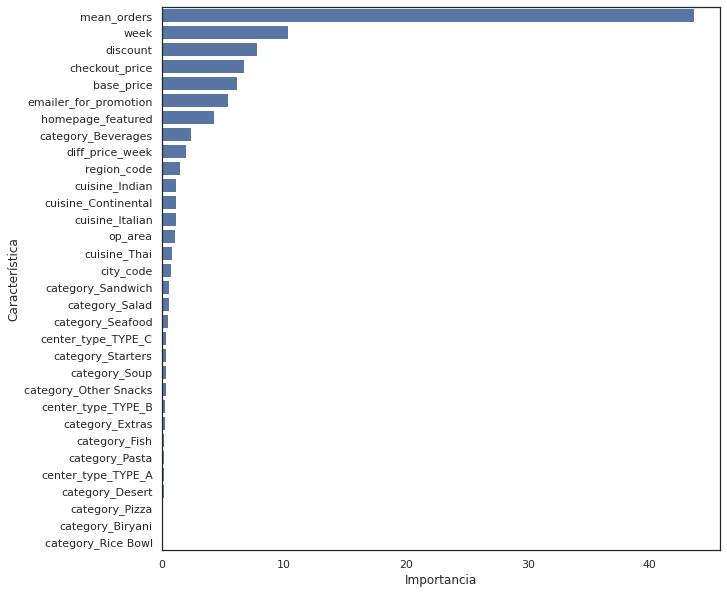

In [71]:
importances = pd.DataFrame({ 'importance': catboost_model.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
# Predicción
y_pred = catboost_model.predict(X_test_dummies)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('catboost_submission_model_1.csv', index=False)

#### Prueba 2: CatBoostRegressor con profundidad 8 sin feature engineering

In [73]:
# Lista de parámetros https://catboost.ai/docs/concepts/python-reference_parameters-list.html?lang=en
x = X_train
y = Y_train
train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []

categorical_columns_indexes = np.where(X_train.dtypes == 'object')[0]

catboost_model_2 = CatBoostRegressor(iterations=2400,
                                   learning_rate=0.01,
                                   max_depth=8,
                                   l2_leaf_reg=10, 
                                   od_type='Iter',
                                   loss_function='RMSE',
                                   use_best_model=True)

kfolds = KFold(n_splits=3, shuffle=True)

for train_idx, val_idx in kfolds.split(x):
  x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
  x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
  catboost_model_2.fit(x_train, y_train,cat_features=categorical_columns_indexes, eval_set=(x_val, y_val), verbose=200)
  train_scores.append(catboost_model_2.score(x_train, y_train))
  val_scores.append(catboost_model_2.score(x_val, y_val))
  train_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_train, catboost_model_2.predict(x_train))))
  val_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_val, catboost_model_2.predict(x_val))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

0:	learn: 1.1941266	test: 1.1938085	best: 1.1938085 (0)	total: 184ms	remaining: 7m 20s
200:	learn: 0.5489501	test: 0.5495242	best: 0.5495242 (200)	total: 35.6s	remaining: 6m 29s
400:	learn: 0.5118051	test: 0.5129231	best: 0.5129231 (400)	total: 1m 8s	remaining: 5m 40s
600:	learn: 0.5011416	test: 0.5023624	best: 0.5023624 (600)	total: 1m 39s	remaining: 4m 56s
800:	learn: 0.4943586	test: 0.4956843	best: 0.4956843 (800)	total: 2m 9s	remaining: 4m 18s
1000:	learn: 0.4896752	test: 0.4911341	best: 0.4911341 (1000)	total: 2m 40s	remaining: 3m 43s
1200:	learn: 0.4858570	test: 0.4874617	best: 0.4874617 (1200)	total: 3m 11s	remaining: 3m 10s
1400:	learn: 0.4827025	test: 0.4844345	best: 0.4844345 (1400)	total: 3m 43s	remaining: 2m 39s
1600:	learn: 0.4799717	test: 0.4818592	best: 0.4818592 (1600)	total: 4m 15s	remaining: 2m 7s
1800:	learn: 0.4779870	test: 0.4800134	best: 0.4800134 (1800)	total: 4m 43s	remaining: 1m 34s
2000:	learn: 0.4762278	test: 0.4783947	best: 0.4783947 (2000)	total: 5m 11s	rem

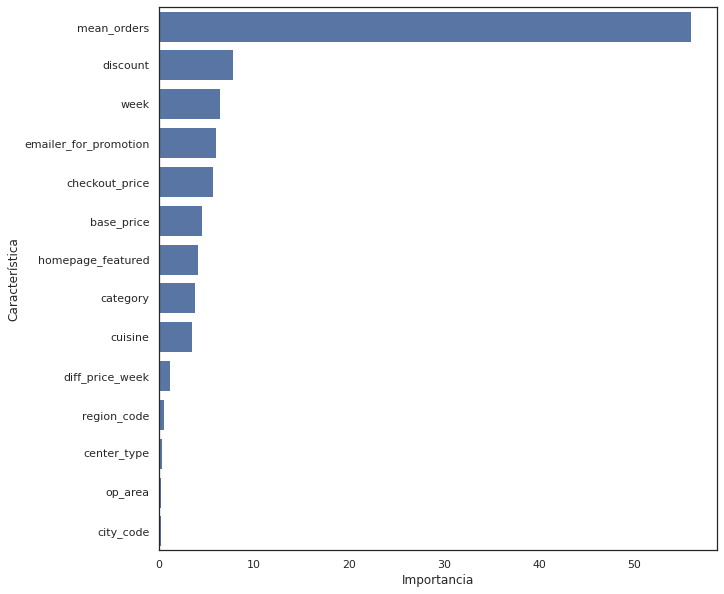

In [74]:
importances = pd.DataFrame({ 'importance': catboost_model_2.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
# Predicción
y_pred = catboost_model_2.predict(X_test)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('catboost_submission_model_2.csv', index=False)

#### Prueba 3: CatBoostRegressor con profuncidad 8 con feature engineering

In [79]:
x = X_train_categorical
y = Y_train
train_scores, val_scores, train_rmsle, val_rmsle = [], [], [], []

categorical_columns_indexes = np.where(X_test_categorical.dtypes == 'object')[0]
#1000
catboost_model_3 = CatBoostRegressor(iterations=1600,
                                   learning_rate=0.01,
                                   max_depth=8,
                                   l2_leaf_reg=8, 
                                   loss_function='RMSE',
                                   use_best_model=True)

kfolds = KFold(n_splits=4, shuffle=True)

for train_idx, val_idx in kfolds.split(x):
  x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
  x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
  catboost_model_3.fit(x_train, y_train, cat_features=categorical_columns_indexes, eval_set=(x_val, y_val), verbose=200)
  train_scores.append(catboost_model_3.score(x_train, y_train))
  val_scores.append(catboost_model_3.score(x_val, y_val))
  train_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_train, catboost_model_3.predict(x_train))))
  val_rmsle.append(100 * np.sqrt(mean_squared_log_error(y_val, catboost_model_3.predict(x_val))))

print(f'Score Promedio')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')
print(f'RMSLE Promedio')
print(f'Train      = {np.mean(train_rmsle):.4}')
print(f'Validation = {np.mean(val_rmsle):.4}')

0:	learn: 1.1939242	test: 1.1940919	best: 1.1940919 (0)	total: 404ms	remaining: 10m 45s
200:	learn: 0.5491085	test: 0.5481664	best: 0.5481664 (200)	total: 1m 11s	remaining: 8m 18s
400:	learn: 0.5111065	test: 0.5104355	best: 0.5104355 (400)	total: 2m 17s	remaining: 6m 51s
600:	learn: 0.4997253	test: 0.4992741	best: 0.4992741 (600)	total: 3m 23s	remaining: 5m 38s
800:	learn: 0.4924339	test: 0.4921402	best: 0.4921402 (800)	total: 4m 29s	remaining: 4m 28s
1000:	learn: 0.4869907	test: 0.4868587	best: 0.4868587 (1000)	total: 5m 34s	remaining: 3m 20s
1200:	learn: 0.4828675	test: 0.4828851	best: 0.4828851 (1200)	total: 6m 39s	remaining: 2m 12s
1400:	learn: 0.4796619	test: 0.4798846	best: 0.4798846 (1400)	total: 7m 53s	remaining: 1m 7s
1599:	learn: 0.4767966	test: 0.4772243	best: 0.4772243 (1599)	total: 9m	remaining: 0us

bestTest = 0.4772242779
bestIteration = 1599

0:	learn: 1.1939288	test: 1.1941521	best: 1.1941521 (0)	total: 403ms	remaining: 10m 43s
200:	learn: 0.5489526	test: 0.5493565	bes

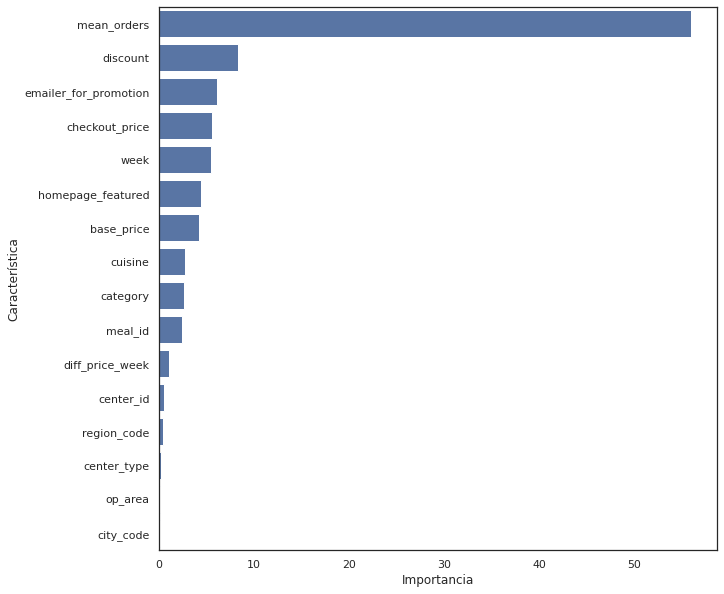

In [82]:
importances = pd.DataFrame({ 'importance': catboost_model_3.feature_importances_ })
importances['feature'] = x.columns
importances_sorted = importances.sort_values(by='importance', ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
fig =sns.barplot(x='importance',
                 y='feature', 
                 data=importances_sorted, 
                 label="Importancia de Características", 
                 color="b")

plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show(fig)

In [0]:
y_pred = catboost_model_3.predict(X_test_categorical)
predictions = pd.DataFrame({'id': ids, 
                           'num_orders': np.expm1(y_pred)})
predictions.to_csv('catboost_submission_model_3.csv', index=False)

## Referencias



1.   Notebook 1
[Food Demand Forecasting](https://github.com/SaiPrasath-S/DemandPrediction)
2.   Notebook 2 [Food Demand Forecasting](https://github.com/yashkim77/AV_Food_Demand_Challenge)
3. Video de Series Temporales [Time Series Analysis](https://www.youtube.com/watch?v=0lsmdNLNorY&list=PLeo1K3hjS3uvMADnFjV1yg6E5nVU4kOob&index=7)
4. Información CatBoost [CatBoost](https://catboost.ai/)
5. Learning Curve [Curva de Aprendizaje](https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/)
